# Agenda

- JSON Structure
- Use Cases
- JSON Functions (JSON_VALUE, JSON_QUERY, OPENJSON, JSON_MODIFY)
- Loading JSON

# Tools

Azure Data Studio / VS Code Format Document (Shift+ Alt+F)

<a href="https://code.visualstudio.com/docs/languages/json" data-href="https://code.visualstudio.com/docs/languages/json" title="https://code.visualstudio.com/docs/languages/json">https://code.visualstudio.com/docs/languages/json</a>

<a href="https://jsonformatter.org/" data-href="https://jsonformatter.org/" title="https://jsonformatter.org/">https://jsonformatter.org/</a>(Validate and formats)

<br>

<br>

[JSON data in SQL Server](https://docs.microsoft.com/en-us/sql/relational-databases/json/json-data-sql-server?view=sql-server-ver15)



# JSON Structure

JSON syntax is derived from JavaScript object notation syntax:

- Data is in name/value pairs
- Data is separated by commas
- Curly braces hold objects
- Square brackets hold arrays


# Data Types

JSON Supports the following Data Types

- a **string** Strings are delimited with double-quotation marks and support a backslash escape
- a **number** 123.00 (int, decimal, or floating point)
- an **object** (JSON object associative array arbitraily nested)
- an **array** [] comma seperated ordered list
- a **boolean** true of false
- **null**

# Sample JSON
```
{
  "Actors": [
    {
      "name": "Tom Cruise",
      "age": 56,
      "Born At": "Syracuse, NY",
      "Birthdate": "July 3, 1962",
      "photo": "https://jsonformatter.org/img/tom-cruise.jpg",
      "wife": null,
      "weight": 67.5,
      "hasChildren": true,
      "hasGreyHair": false,
      "children": [
        "Suri",
        "Isabella Jane",
        "Connor"
      ]
    },
    {
      "name": "Robert Downey Jr.",
      "age": 53,
      "Born At": "New York City, NY",
      "Birthdate": "April 4, 1965",
      "photo": "https://jsonformatter.org/img/Robert-Downey-Jr.jpg",
      "wife": "Susan Downey",
      "weight": 77.1,
      "hasChildren": true,
      "hasGreyHair": false,
      "children": [
        "Indio Falconer",
        "Avri Roel",
        "Exton Elias"
      ]
    }
  ]
}
```


Notes:

- JSON is defined in 
- No support for comments
- NULL values are usually omited

# Use Cases and Support

# Use Cases

- Flexible Logging Structure
- Flexible Schema Type -\> Sub Type Relationships
- Storing configuration values
- Document oriented models (where we tend to update the entire document if at all)

*Not A replacement for good data modeling practices*

# Sources

- IoT
- Logs
- Rest | Web API's

# JSON Alternatives

- Entity Atribute Value Pattern (EAV)
- Many To Many (bridge Table)
- XML Data Type
- NoSQL DB (Such as azure CosmosDB)

# Overview of built-in JSON Support

- Support for JSON was added in SQL Server 2016
- JSON support exists in both Azure SQL Database and Azure Synapse Analytics (SQL DW)

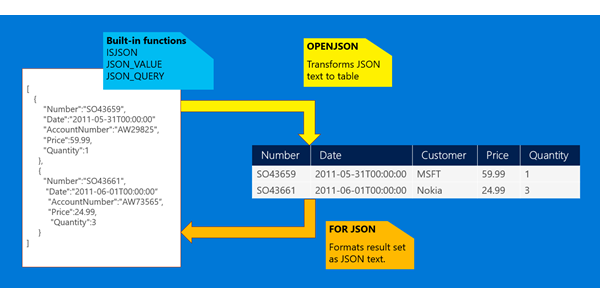

# Storing JSON Data
 - > up to 2gb of data can be stored in either a varchar(max) or nvchar(max)

- > if you know the size of the json will be less than 8kb you can use or varchar(4000) varchar(8000)
  performance benifit for storing data on page

```
 CREATE TABLE dbo.Movies (
    MovieId int identity(1,1) NOT NULL, 
    MovieData VARCHAR(MAX)
);

-- check constraints (prevent bad JSON)
ALTER TABLE [dbo].[Movies]  
   ADD CONSTRAINT [CK_Movies_MovieData] 
   CHECK  (IsJson([MovieData]) > 0)

```

# Compressing JSON data
SQL Server supports gzip compression via COMPRESS and DECOMPRESS functions on data however this is incompatible with indexing strategies (covered later)

```

CREATE TABLE dbo.Movies (  
    MovieId INT PRIMARY KEY IDENTITY,    
    MovieData VARBINARY(max),  
    MovieJson as CAST(DECOMPRESS(MovieData) as VARCHAR(max))  
);  

INSERT INTO dbo.Movies ()  
VALUES (COMPRESS(N'{"sport":"Tennis","age": 28,"rank":1,"points":15258, turn":17}'));  

-- Return data
SELECT MovieId,  
             CAST(DECOMPRESS(MovieData) AS VARCHAR(MAX)) AS info  
FROM dbo.Movies;  


SELECT MovieId,  
             ,MovieJson
FROM dbo.Movies;  

```


# JSON\_VALUE

Extracts a scalar value (only) from a JSON string.

supports two modes of evaluation:

- lax (Default)
- strict

lax will return null if there is a missing path or other issue.
strict will return an error message if the path isn't found or if you try to use a scalar function on a collection or object

In [3]:
-- JSON Basics JSON_VALUE JSON_QUERY, JSON_MODIFY

DECLARE @JsonData nvarchar(max) = N'
{
   "info": {
      "type": 1,
      "address": {
         "town": "Bristol",
         "county": "Avon",
         "country": "England"
      },
      "tags": ["Sport", "Water polo"]
   },
   "type": "Basic"
} 
';

SELECT ISJSON(@jsonData);

SELECT 
   JSON_VALUE(@JsonData, '$.info.address.town') as town
  ,JSON_QUERY(@JsonData,'$.info.address') as addressjson;


SELECT JSON_QUERY(@JsonData,' strict $.info.tags'); 

(1 row affected)

(1 row affected)

Total execution time: 00:00:00.123

(No column name)
1


town,addressjson
Bristol,"{ ""town"": ""Bristol"", ""county"": ""Avon"", ""country"": ""England"" }"


# JSON\_QUERY

Allows you to return an object or an array from a JSON document

In [4]:

DECLARE @JsonData nvarchar(max) = N'
{
   "info": {
      "type": 1,
      "address": {
         "town": "Bristol",
         "county": "Avon",
         "country": "England"
      },
      "tags": ["Sport", "Water polo"]
   },
   "type": "Basic"
} 
';

SELECT 

JSON_QUERY(@JsonData,'$.info.tags') as tags;



(1 row affected)

Total execution time: 00:00:00.047

tags
"[""Sport"", ""Water polo""]"


# Handling multiple rows with OPENJSON

OPENJSON is used to is used to return a row of data for each object or array.

it can be used in two ways:<br>

implicit schema

or explicit schema using the with

more info: <a href="https://docs.microsoft.com/en-us/sql/t-sql/functions/openjson-transact-sql?view=sql-server-ver15" data-href="https://docs.microsoft.com/en-us/sql/t-sql/functions/openjson-transact-sql?view=sql-server-ver15" title="https://docs.microsoft.com/en-us/sql/t-sql/functions/openjson-transact-sql?view=sql-server-ver15">OPENJSON (Transact-SQL)</a>

In [9]:
 -- Dealing with Multiple rows
DECLARE @JsonData nvarchar(max) = N'
{
  "name":"John",
  "age":30,
  "cars": [
    { "name":"Ford", "models":[ "Fiesta", "Focus", "Mustang" ] },
    { "name":"BMW", "models":[ "320", "X3", "X5" ] },
    { "name":"Fiat", "models":[ "500", "Panda" ] }
  ]
 }';

SELECT
   JSON_VALUE(@JsonData, '$.name') as town
  ,JSON_VALUE(@JsonData, '$.age') as county
  ,m.[Name]
  ,m.models
  ,m1.NAME
FROM OPENJSON(@JsonData, '$.cars' )
 WITH (   
              [name]   varchar(100)   '$.name',  
              models   nvarchar(max) AS JSON
 ) m
 CROSS APPLY OPENJSON(m.models) m1; 


(8 rows affected)

Total execution time: 00:00:00.049

town,county,Name,models,key,value,type
John,30,Ford,"[ ""Fiesta"", ""Focus"", ""Mustang"" ]",0,Fiesta,1
John,30,Ford,"[ ""Fiesta"", ""Focus"", ""Mustang"" ]",1,Focus,1
John,30,Ford,"[ ""Fiesta"", ""Focus"", ""Mustang"" ]",2,Mustang,1
John,30,BMW,"[ ""320"", ""X3"", ""X5"" ]",0,320,1
John,30,BMW,"[ ""320"", ""X3"", ""X5"" ]",1,X3,1
John,30,BMW,"[ ""320"", ""X3"", ""X5"" ]",2,X5,1
John,30,Fiat,"[ ""500"", ""Panda"" ]",0,500,1
John,30,Fiat,"[ ""500"", ""Panda"" ]",1,Panda,1


# Replace JSON\_VALUE With CROSS APPLY OPENJSON

In [ ]:
SELECT 
	 ETLControlId
	,SourceSystem
	,ActivityName
	-- transform
	,t.*
    ,t.TransformType
	/*
      
	,JSON_VALUE(ActivityMetadata, '$.transform.type') AS TransformType
	,JSON_VALUE(ActivityMetadata, '$.transform.typeProperties.sqlReaderStoredProcedureName') AS ProcedureName
	,JSON_VALUE(ActivityMetadata, '$.transform.typeProperties.querytimeout') AS QueryTimeout
	,JSON_VALUE(ActivityMetadata, '$.transform.typeProperties.partitionColumnName') AS PartitionColumnName
	,JSON_VALUE(ActivityMetadata, '$.transform.typeProperties.partitionMinValue') AS PartitionMinValue
	,JSON_VALUE(ActivityMetadata, '$.transform.typeProperties.partitionMaxValue') AS PartitionMaxValue
	*/
	,JSON_QUERY(ActivityMetadata, '$.transform') AS Transform
	,isjson(ActivityMetadata) ActivityIsJson
	,IsActive
    ,RequireSuccess
	FROM [Etl].[ETLControl]
    CROSS APPLY OPENJSON (JSON_QUERY(ActivityMetadata, '$.transform'))
    WITH (   
	          TransformType       sysname '$.type',  
              ProcedureName       sysname '$.typeProperties.sqlReaderStoredProcedureName',  
              QueryTimeOut        int     '$.typeProperties.querytimeout',  
              PartitionColumnName sysname '$.typeProperties.partitionColumnName',  
			  PartitionMinValue   date    '$.typeProperties.partitionMinValue',  
			  PartitionMaxValue   date    '$.typeProperties.partitionMaxValue'  
              
 ) as t
GO

/* Code is simplified

# JSON\_MODIFY

JSON_MODIFY allows you to perform modification operations against a JSON Document


In [10]:
DECLARE @JsonData nvarchar(max) = N'
{
   "info": {
      "type": 1,
      "address": {
         "town": "Bristol",
         "county": "Avon",
         "country": "England"
      },
      "tags": ["Sport", "Water polo"]
   },
   "type": "Basic"
} 
';

SELECT 
   JSON_VALUE(@JsonData, '$.info.address.town') as town
  ,JSON_VALUE(@JsonData, '$.info.address.county') as county
  ,JSON_VALUE(@JsonData, '$.info.address.country') as country
  ,JSON_QUERY(@JsonData,'$.info.tags') as tags;

-- Update
SET @JsonData=JSON_MODIFY(@JsonData,' lax $.info.address.town','Portishead');

SELECT JSON_VALUE(@JsonData, '$.info.address.town') as town;

-- Insert
SET @JsonData=JSON_MODIFY(@JsonData,' lax $.info.address.foo','bar');

SELECT JSON_QUERY(@JsonData, '$.info.address') as town;

-- Delete
SET @JsonData=JSON_MODIFY(@JsonData,' lax $.info.address.foo', null);

SELECT JSON_QUERY(@JsonData, '$.info.address') as town;


-- Appending to an Array
SET @JsonData=JSON_MODIFY(@JsonData,'append $.info.tags','Football')

SELECT JSON_QUERY(@JsonData,' strict $.info.tags') 

(1 row affected)

(1 row affected)

(1 row affected)

(1 row affected)

Total execution time: 00:00:00.062

town,county,country,tags
Bristol,Avon,England,"[""Sport"", ""Water polo""]"


town
Portishead


town
"{ ""town"": ""Portishead"", ""county"": ""Avon"", ""country"": ""England"" ,""foo"":""bar""}"


town
"{ ""town"": ""Portishead"", ""county"": ""Avon"", ""country"": ""England"" }"


# Setting Up Azure Storage Accounts

before loading the data into SQL, you must first create a Master Key, Credential and Data Source:

```
CREATE MASTER KEY ENCRYPTION BY PASSWORD = 'fc74a276-22aa-48b8-8bf4-a16223e32441';
GO

CREATE DATABASE SCOPED CREDENTIAL blob_SAS
WITH
  IDENTITY = 'SHARED ACCESS SIGNATURE',
  -- Remove ? from the beginning of the SAS token
  SECRET = 'sv=2019-12-12&ss=b&srt=sco&sp=rwdlacx&se=2020-12-13T02:26:05Z&st=2020-11-18T08:26:05Z&spr=https&sig=%2B314%2Fm0rgRWeTBgUCRlgaZvoLinwN5G3rQuY2%2Brjs8w%3D' ;

  CREATE DATABASE SCOPED CREDENTIAL blob_SAS
WITH
  IDENTITY = 'SHARED ACCESS SIGNATURE',
  -- Remove ? from the beginning of the SAS token
  SECRET = 'sv=2019-12-12&ss=b&srt=sco&sp=rwdlacx&se=2020-12-13T02:26:05Z&st=2020-11-18T08:26:05Z&spr=https&sig=%2B314%2Fm0rgRWeTBgUCRlgaZvoLinwN5G3rQuY2%2Brjs8w%3D' ;

    CREATE DATABASE SCOPED CREDENTIAL adls_SAS
WITH
  IDENTITY = 'SHARED ACCESS SIGNATURE',
  -- Remove ? from the beginning of the SAS token
  SECRET = 'sv=2019-12-12&ss=bfqt&srt=sco&sp=rwdlacupx&se=2020-12-13T03:34:30Z&st=2020-11-18T18:34:30Z&spr=https&sig=dcM8eMVPTCnDpoHCSy%2FmrZYpmOZPqNrD7mW3iDsP6H0%3D' ;

Note: this works with on-premises SQL Server as well and can access the local filesystem (including a SMB fileshare) or azure storage
CREATE EXTERNAL DATA SOURCE ds_blob_storage
 WITH ( TYPE = BLOB_STORAGE,
        LOCATION = 'https://jsonbs.blob.core.windows.net/data',
        CREDENTIAL= blob_SAS);

CREATE EXTERNAL DATA SOURCE ds_adls_storage
 WITH ( TYPE = BLOB_STORAGE,
        LOCATION = 'https://adfdpadlsv2.blob.core.windows.net/blob',
        CREDENTIAL= adls_SAS);
```

# Querying with OPENROWSET

by default OPENROWSET will return the data into a single column (called BulkColumn)

In [60]:
 SELECT *
 FROM OPENROWSET (
   BULK 'MOCK_DATA.json'
 , DATA_SOURCE = 'ds_blob_storage'
 , SINGLE_CLOB
 ) as j
 CROSS APPLY OPENJSON(BulkColumn);       

Total execution time: 00:00:00

# Shaping Query Results with OPENROWSET
in order to make the data more structured or tabular you can cross apply and use the same technique for the defining the schema with the OPENJSON Function

In [61]:
 SELECT 
  id
 ,first_name
 ,last_name 
 FROM OPENROWSET (
   BULK 'MOCK_DATA.json',
   DATA_SOURCE = 'ds_adls_storage',
   SINGLE_CLOB
   ) AS j
   CROSS APPLY OPENJSON(BulkColumn)
   WITH (   
              id       int   '$.id',  
              first_name     varchar(100) '$.first_name',
			  last_name     varchar(100) '$.last_name'
 );

Total execution time: 00:00:00

# Bulk Inserting JSON Data From Azure Storage
Data from the JSON document can also be bulk inserted into a table in SQL

In [62]:
DROP TABLE #mydata;

CREATE TABLE #mydata (
    jsondata NVARCHAR(MAX)

);

BULK INSERT #mydata
FROM 'MOCK_DATA.json'
WITH ( DATA_SOURCE = 'ds_blob_storage');

BULK INSERT #mydata
FROM 'MOCK_DATA.json'
WITH ( DATA_SOURCE = 'ds_adls_storage');

SELECT * FROM #mydata;

Total execution time: 00:00:00

# Returning JSON From Relational Tables

JSON can also be returning from a table by using the FOR JSON construct.

you can use either FOR JSON AUTO or provide more control by using FOR JSON PATH and optionally further control the output with the following options:

- INCLUDE\_NULL\_VALUES
- WITHOUT\_ARRAY\_WRAPPER
- ROOT() Cannot be specified with WITHOUT\_ARRAY\_WRAPPER

In [3]:
 SELECT top 10
 * 
 FROM [SalesLT].[Customer]
 FOR JSON AUTO;

 -- INCLUDE_NULL_VALUES    
 -- WITHOUT_ARRAY_WRAPPER 

 SELECT TOP 10
  CustomerId as 'Id'
 ,FirstName  as 'first'
 ,LastName   as 'last'
 ,EmailAddress 
 ,PasswordHash as 'Password.Hash'
 ,PasswordSalt as 'Password.Salt'
 FROM [SalesLT].[Customer]
 FOR JSON PATH, ROOT('Customers');

 /* TODO Show example of Nested objects / arrays */


 /*  capture output to variable

 DECLARE @JSONData NVARCHAR(MAX) = (
     /* select goes here*/
 )
 */


 /*

 From UDF: RETURN ( Query here)

 */

(10 rows affected)

(10 rows affected)

Total execution time: 00:00:00.125

JSON_F52E2B61-18A1-11d1-B105-00805F49916B


JSON_F52E2B61-18A1-11d1-B105-00805F49916B
"{""Customers"":[{""Id"":1,""first"":""Orlando"",""last"":""Gee"",""EmailAddress"":""orlando0@adventure-works.com"",""Password"":{""Hash"":""L\/Rlwxzp4w7RWmEgXX+\/A7cXaePEPcp+KwQhl2fJL7w="",""Salt"":""1KjXYs4=""}},{""Id"":2,""first"":""Keith"",""last"":""Harris"",""EmailAddress"":""keith0@adventure-works.com"",""Password"":{""Hash"":""YPdtRdvqeAhj6wyxEsFdshBDNXxkCXn+CRgbvJItknw="",""Salt"":""fs1ZGhY=""}},{""Id"":3,""first"":""Donna"",""last"":""Carreras"",""EmailAddress"":""donna0@adventure-works.com"",""Password"":{""Hash"":""LNoK27abGQo48gGue3EBV\/UrlYSToV0\/s87dCRV7uJk="",""Salt"":""YTNH5Rw=""}},{""Id"":4,""first"":""Janet"",""last"":""Gates"",""EmailAddress"":""janet1@adventure-works.com"",""Password"":{""Hash"":""ElzTpSNbUW1Ut+L5cWlfR7MF6nBZia8WpmGaQPjLOJA="",""Salt"":""nm7D5e4=""}},{""Id"":5,""first"":""Lucy"",""last"":""Harrington"",""EmailAddress"":""lucy0@adventure-works.com"",""Password"":{""Hash"":""KJqV15wsX3PG8TS5GSddp6LFFVdd3CoRftZM\/tP0+R4="",""Salt"":""cNFKU4w=""}},{""Id"":6,""first"":""Rosmarie"",""last"":""Carroll"",""EmailAddress"":""rosmarie0@adventure-works.com"",""Password"":{""Hash"":""OKT0scizCdIzymHHOtyJKQiC\/fCILSooSZ8dQ2Y34VM="",""Salt"":""ihWf50M=""}},{""Id"":7,""first"":""Dominic"",""last"":""Gash"",""EmailAddress"":""dominic0@adventure-works.com"",""Password"":{""Hash"":""ZccoP\/jZGQm+Xpzc7RKwDhS11YFNybwcPVRYTSNcnSg="",""Salt"":""sPoUBSQ=""}},{""Id"":10,""first"":""Kathleen"",""last"":""Garza"",""EmailAddress"":""kathleen0@adventure-works.com"",""Password"":{""Hash"":""Qa3aMCxNbVLGrc0b99KsbQqiVgwYDfHcsK9GZSUxcTM="",""Salt"":""Ls05W3g=""}},{""Id"":11,""first"":""Katherine"",""last"":""Harding"",""EmailAddress"":""katherine0@adventure-works.com"",""Password"":{""Hash"":""uRlorVzDGNJIX9I+ehTlRK+liT4UKRgWhApJgUMC2d4="",""Salt"":""jpHKbqE=""}},{""Id"":12,""first"":""Johnny"",""last"":""Caprio"",""EmailAddress"":""johnny0@adventure-works.com"",""Password"":{""Hash"":""jtF9jBoFYeJTaET7x+eJDkd7BzMz15Wo9odbGPBaIak="",""Salt"":""wVLnvHo=""}}]}"


# Dynamic IN Clause

**Scenario** _you want to provide a parameterized list of values to a stored procedure function or query_

In [4]:
 SELECT * FROM [SalesLT].[Product]
 WHERE ProductCategoryId IN ( 25,18,33) -- Hard coding makes me :(



DECLARE @pSearchOptions NVARCHAR(4000) = N'[25,18,33]'

SELECT *
FROM [SalesLT].[Product] p
INNER JOIN OPENJSON(@pSearchOptions) AS category
 ON p.ProductCategoryID = category.value
-- How to make this dynamic? JSON :)

(42 rows affected)

(42 rows affected)

Total execution time: 00:00:00.538

ProductID Name ProductNumber Color StandardCost ListPrice Size Weight ProductCategoryID ProductModelID SellStartDate SellEndDate DiscontinuedDate ThumbNailPhoto ThumbnailPhotoFileName rowguid ModifiedDate 680 HL Road Frame - Black, 58 FR-R92B-58 Black 1059.31 1431.50 58 1016.04 18 6 2002-06-01 00:00:00.000 NULL NULL 0x47494638396150003100F70000000000800000008000808000000080800080008080808080C0C0C0FF000000FF00FFFF000000FFFF00FF00FFFFFFFFFF0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000330000660000990000CC0000FF0033000033330033660033990033CC0033FF0066000066330066660066990066CC0066FF0099000099330099660099990099CC0099FF00CC0000CC3300CC6600CC9900CCCC00CCFF00FF0000FF3300FF6600FF9900FFCC00FFFF3300003300333300663300993300CC3300FF3333003333333333663333993333CC3333FF3366003366333366663366993366CC3366FF3399003399333399663399993399CC3399FF33CC0033CC3333CC6633CC9933CCCC33CCFF33FF0033FF3333FF6633FF9933FFCC33FFFF6600006600336600666600996600CC6600FF6633006633336633666633996633CC6633FF6666006666336666666666996666CC6666FF6699006699336699666699996699CC6699FF66CC0066CC3366CC6666CC9966CCCC66CCFF66FF0066FF3366FF6666FF9966FFCC66FFFF9900009900339900669900999900CC9900FF9933009933339933669933999933CC9933FF9966009966339966669966999966CC9966FF9999009999339999669999999999CC9999FF99CC0099CC3399CC6699CC9999CCCC99CCFF99FF0099FF3399FF6699FF9999FFCC99FFFFCC0000CC0033CC0066CC0099CC00CCCC00FFCC3300CC3333CC3366CC3399CC33CCCC33FFCC6600CC6633CC6666CC6699CC66CCCC66FFCC9900CC9933CC9966CC9999CC99CCCC99FFCCCC00CCCC33CCCC66CCCC99CCCCCCCCCCFFCCFF00CCFF33CCFF66CCFF99CCFFCCCCFFFFFF0000FF0033FF0066FF0099FF00CCFF00FFFF3300FF3333FF3366FF3399FF33CCFF33FFFF6600FF6633FF6666FF6699FF66CCFF66FFFF9900FF9933FF9966FF9999FF99CCFF99FFFFCC00FFCC33FFCC66FFCC99FFCCCCFFCCFFFFFF00FFFF33FFFF66FFFF99FFFFCCFFFFFF21F90401000010002C00000000500031000008FF00FF091C48B0A0C18308132A5CC8B0A1C38710234A9C48B1A2C58B18336ADCC8B1A3C78F20438A1C49B2A4C9932853AA5C9911058A812E17C664F9D0E5CB7F3313E6A4C9D0A6C099366FC27C19D367CEA04371DE44CA1169D1A542952A25FA1467D2A7547F46C558542AD0A855A58A9D9AD52BD4A654C3EE547BD6AC58AC3E377E2DBB96EED9AF6FCB7A9C9B97205BAD7DB1F6952B74EED6BF79E3B2DDC95362E1AD8D2F328D4CB9B2E5CB9831C77518D62063C6223743040DD82F6490558FA6BD0B152F5EB2A8B3AA7EEC96B651D96D3BFE9D8D7BE86EBB1F7F034ECD3AF06AD292831237EEB6F9F290AAB5B65DEE9A7A6EC249A7FA7EAEDC79EBD399C38B121F4FBEBCF9F3E8D3AB5FCFBEBDFBF7EF0302003B no_image_available_small.gif 43dd68d6-14a4-461f-9069-55309d90ea7e 2008-03-11 10:01:36.827 706 HL Road Frame - Red, 58 FR-R92R-58 Red 1059.31 1431.50 58 1016.04 18 6 2002-06-01 00:00:00.000 NULL NULL 0x47494638396150003100F70000000000800000008000808000000080800080008080808080C0C0C0FF000000FF00FFFF000000FFFF00FF00FFFFFFFFFF0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000330000660000990000CC0000FF0033000033330033660033990033CC0033FF0066000066330066660066990066CC0066FF0099000099330099660099990099CC0099FF00CC0000CC3300CC6600CC9900CCCC00CCFF00FF0000FF3300FF6600FF9900FFCC00FFFF3300003300333300663300993300CC3300FF3333003333333333663333993333CC3333FF3366003366333366663366993366CC3366FF3399003399333399663399993399CC3399FF33CC0033CC3333CC6633CC9933CCCC33CCFF33FF0033FF3333FF6633FF9933FFCC33FFFF6600006600336600666600996600CC6600FF6633006633336633666633996633CC6633FF6666006666336666666666996666CC6666FF6699006699336699666699996699CC6699FF66CC0066CC3366CC6666CC9966CCCC66CCFF66FF0066FF3366FF6666FF9966FFCC66FFFF9900009900339900669900999900CC9900FF9933009933339933669933999933CC9933FF9966009966339966669966999966CC9966FF9999009999339999669999999999CC9999FF99CC0099CC3399CC6699CC9999CCCC99CCFF99FF0099FF3399FF6699FF9999FFCC99FFFFCC0000CC0033CC0066CC0099CC00CCCC00FFCC3300CC3333CC3366CC3399CC33CCCC33FFCC6600CC6633CC6666CC6699CC66CCCC66FFCC9900CC9933CC9966CC9999CC99CCCC99FFCCCC00CCCC33CCCC66CCCC99CCCCCCCCCCFFCCFF00CCFF33CC

ProductID Name ProductNumber Color StandardCost ListPrice Size Weight ProductCategoryID ProductModelID SellStartDate SellEndDate DiscontinuedDate ThumbNailPhoto ThumbnailPhotoFileName rowguid ModifiedDate key value type 680 HL Road Frame - Black, 58 FR-R92B-58 Black 1059.31 1431.50 58 1016.04 18 6 2002-06-01 00:00:00.000 NULL NULL 0x47494638396150003100F70000000000800000008000808000000080800080008080808080C0C0C0FF000000FF00FFFF000000FFFF00FF00FFFFFFFFFF0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000330000660000990000CC0000FF0033000033330033660033990033CC0033FF0066000066330066660066990066CC0066FF0099000099330099660099990099CC0099FF00CC0000CC3300CC6600CC9900CCCC00CCFF00FF0000FF3300FF6600FF9900FFCC00FFFF3300003300333300663300993300CC3300FF3333003333333333663333993333CC3333FF3366003366333366663366993366CC3366FF3399003399333399663399993399CC3399FF33CC0033CC3333CC6633CC9933CCCC33CCFF33FF0033FF3333FF6633FF9933FFCC33FFFF6600006600336600666600996600CC6600FF6633006633336633666633996633CC6633FF6666006666336666666666996666CC6666FF6699006699336699666699996699CC6699FF66CC0066CC3366CC6666CC9966CCCC66CCFF66FF0066FF3366FF6666FF9966FFCC66FFFF9900009900339900669900999900CC9900FF9933009933339933669933999933CC9933FF9966009966339966669966999966CC9966FF9999009999339999669999999999CC9999FF99CC0099CC3399CC6699CC9999CCCC99CCFF99FF0099FF3399FF6699FF9999FFCC99FFFFCC0000CC0033CC0066CC0099CC00CCCC00FFCC3300CC3333CC3366CC3399CC33CCCC33FFCC6600CC6633CC6666CC6699CC66CCCC66FFCC9900CC9933CC9966CC9999CC99CCCC99FFCCCC00CCCC33CCCC66CCCC99CCCCCCCCCCFFCCFF00CCFF33CCFF66CCFF99CCFFCCCCFFFFFF0000FF0033FF0066FF0099FF00CCFF00FFFF3300FF3333FF3366FF3399FF33CCFF33FFFF6600FF6633FF6666FF6699FF66CCFF66FFFF9900FF9933FF9966FF9999FF99CCFF99FFFFCC00FFCC33FFCC66FFCC99FFCCCCFFCCFFFFFF00FFFF33FFFF66FFFF99FFFFCCFFFFFF21F90401000010002C00000000500031000008FF00FF091C48B0A0C18308132A5CC8B0A1C38710234A9C48B1A2C58B18336ADCC8B1A3C78F20438A1C49B2A4C9932853AA5C9911058A812E17C664F9D0E5CB7F3313E6A4C9D0A6C099366FC27C19D367CEA04371DE44CA1169D1A542952A25FA1467D2A7547F46C558542AD0A855A58A9D9AD52BD4A654C3EE547BD6AC58AC3E377E2DBB96EED9AF6FCB7A9C9B97205BAD7DB1F6952B74EED6BF79E3B2DDC95362E1AD8D2F328D4CB9B2E5CB9831C77518D62063C6223743040DD82F6490558FA6BD0B152F5EB2A8B3AA7EEC96B651D96D3BFE9D8D7BE86EBB1F7F034ECD3AF06AD292831237EEB6F9F290AAB5B65DEE9A7A6EC249A7FA7EAEDC79EBD399C38B121F4FBEBCF9F3E8D3AB5FCFBEBDFBF7EF0302003B no_image_available_small.gif 43dd68d6-14a4-461f-9069-55309d90ea7e 2008-03-11 10:01:36.827 1 18 2 706 HL Road Frame - Red, 58 FR-R92R-58 Red 1059.31 1431.50 58 1016.04 18 6 2002-06-01 00:00:00.000 NULL NULL 0x47494638396150003100F70000000000800000008000808000000080800080008080808080C0C0C0FF000000FF00FFFF000000FFFF00FF00FFFFFFFFFF0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000330000660000990000CC0000FF0033000033330033660033990033CC0033FF0066000066330066660066990066CC0066FF0099000099330099660099990099CC0099FF00CC0000CC3300CC6600CC9900CCCC00CCFF00FF0000FF3300FF6600FF9900FFCC00FFFF3300003300333300663300993300CC3300FF3333003333333333663333993333CC3333FF3366003366333366663366993366CC3366FF3399003399333399663399993399CC3399FF33CC0033CC3333CC6633CC9933CCCC33CCFF33FF0033FF3333FF6633FF9933FFCC33FFFF6600006600336600666600996600CC6600FF6633006633336633666633996633CC6633FF6666006666336666666666996666CC6666FF6699006699336699666699996699CC6699FF66CC0066CC3366CC6666CC9966CCCC66CCFF66FF0066FF3366FF6666FF9966FFCC66FFFF9900009900339900669900999900CC9900FF9933009933339933669933999933CC9933FF9966009966339966669966999966CC9966FF9999009999339999669999999999CC9999FF99CC0099CC3399CC6699CC9999CCCC99CCFF99FF0099FF3399FF6699FF9999FFCC99FFFFCC0000CC0033CC0066CC0099CC00CCCC00FFCC3300CC3333CC3366CC3399CC33CCCC33FFCC6600CC6633CC6666CC6699CC66CCCC66FFCC9900CC9933CC9966CC9999CC99CCCC99FFCCCC00CCCC33CCCC66CCCC99CCCC

# Indexing and performance

use clustered columnstore index for Log workloads that are primarily write once and query many times

use Memory optimized tables and compiled stored procedures to reduce CPU and improve concurrency


In [ ]:


-- indexing (improve performance)
ALTER TABLE Sales.SalesOrderHeader
ADD vCustomerName AS JSON_VALUE(Info,'$.Customer.Name')

CREATE INDEX idx_soh_json_CustomerName
ON Sales.SalesOrderHeader(vCustomerName)  

-- Covering indexes
CREATE INDEX idx_soh_json_CustomerName
ON Sales.SalesOrderHeader(vCustomerName)
INCLUDE(SalesOrderNumber,OrderDate)




-- Really Improve Performance
Clustered Columnstore Indexes (CCI)
-- https://docs.microsoft.com/en-us/sql/relational-databases/json/store-json-documents-in-sql-tables?view=sql-server-ver15#large-tables--columnstore-format




In-memory OLTP Support (IMOLTP)


-- https://docs.microsoft.com/en-us/sql/relational-databases/json/store-json-documents-in-sql-tables?view=sql-server-ver15#frequently-changing-documents--memory-optimized-tables


# Resources

the notebook: https://github.com/jasonhorner/JasonOnJson

In [1]:
-- No clue why this is here :)
SELECT PI();

(1 row affected)

Total execution time: 00:00:00.123

(No column name)
3.141592653589793
